In [1]:
# 1) domínio do problema (instâncias EA-VRP)
from qvrp.domain.instance_generator import InstanceGenerator
from qvrp.domain.graphs import GraphBuilder

# 2) pipeline clássico: constraints → encoder → QUBO → decoder
from qvrp.core.constraints import TaxiConstraints
from qvrp.core.encoder import Encoder
from qvrp.core.qubo import QUBOBase
from qvrp.core.decoder import Decoder

# 3) solver quântico (PennyLane QAOA)
from qvrp.solver.pennylane.qaoa import QAOASolver, QAOAConfig

# (opcional) vizualização / análise
from pennylane import numpy as np

# helpers
from qvrp.utils.plot import plot_histogram
from qvrp.utils.time import get_time, run_time


In [6]:
# Exemplo genérico – ajuste para a sua API
gen = InstanceGenerator(
        n_passengers=2,
        n_vehicles=1,
        n_recharges=0,
        n_depots=0,
        area_lat=(-23.70, -23.40),
        area_lon=(-46.80, -46.40),
        seed=42,
    )

passengers, vehicles, recharges, depots = gen.create()


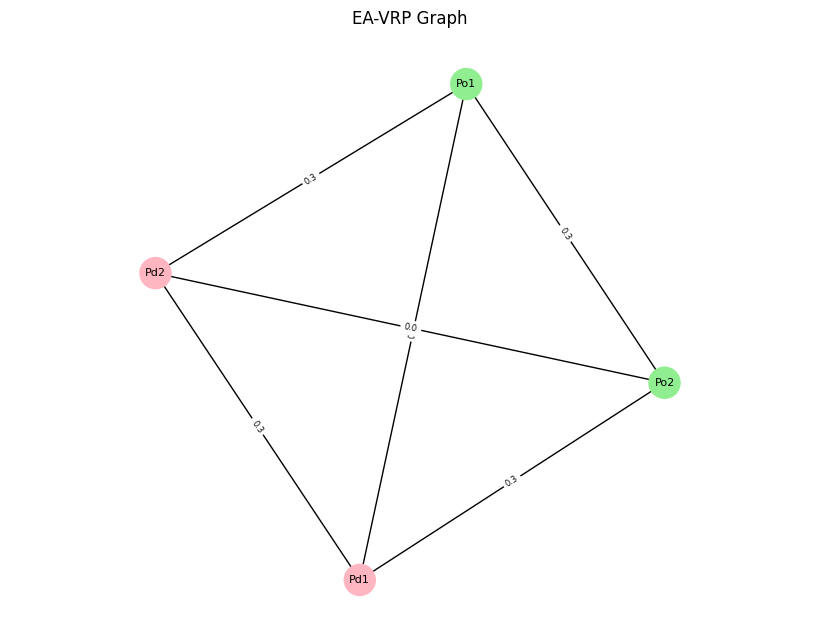

In [3]:
builder = GraphBuilder(passengers, None, depots, recharges)
G = builder.build()
builder.draw()

In [7]:
# 1) constraints do problema (penalidades, limites, etc.)
constraints = TaxiConstraints(
    penalty_params={
        "assignment": 10.0,
        "flow": 20.0,
    }
)

# 2) encoder: transforma instance + constraints → representação de energia
encoder = Encoder(
    graph=G,
    num_vehicles=len(vehicles),
    constraints_handler=constraints,
)

Q, c, offset, var_index = encoder.encode()

# 3) QUBO: objeto QUBOBase usado pelo solver quântico
qubo_model = QUBOBase.from_encoder_output(Q, c, offset, var_index)

# opcional: inspecionar informação básica do QUBO
print("Número de variáveis:", qubo_model.num_vars)
print("Energia de um bitstring zero:", qubo_model.energy([0] * qubo_model.num_vars))


Número de variáveis: 12
Energia de um bitstring zero: 40.0


In [8]:
# Configuração do QAOA
num_shots = 1024
qaoa_cfg = QAOAConfig(
    layers=2,               # profundidade (número de camadas)
    max_iterations=50, # passos do otimizador clássico
    stepsize=0.1,      # passo do gradiente
    shots=num_shots,        # shots para amostragem final
    seed=42,           # reprodutibilidade
    device_name="lightning.qubit",  # pode trocar para outro device PennyLane
)
import time
start = get_time()
solver = QAOASolver(qubo_model=qubo_model, config=qaoa_cfg)

result = solver.run()
finish = get_time()
print("Bitstring encontrado:", result.bitstring)
print("Energia clássica:", result.energy)
print("Número de bitstrings amostrados:", sum(result.raw_samples.values()))
print(f"Tempo de execução: {run_time(start, finish)}")

Bitstring encontrado: [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]
Energia clássica: 100.0
Número de bitstrings amostrados: 1024
Tempo de execução: 0:00:00.632134


/opt/conda/lib/python3.11/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


In [ ]:
decoder = Decoder(
    graph=G,
    num_vehicles = len(vehicles),
    var_index=var_index,
)

sorted_counts = sorted(result.raw_samples.items(), key=lambda kv: kv[1], reverse=True)
best_str, count = sorted_counts[0]

bitstring = [int(b) for b in best_str]

solution = decoder.decode(bitstring)


print("Feasible:", solution.is_feasible)
print("Routes:", solution.routes)
print("Total cost:", solution.total_cost)
print("Violations:", solution.violated_constraints)


In [ ]:
E_qubo = qubo_model.energy(result.bitstring)
print("Energia via QUBOBase.energy:", E_qubo)


In [ ]:
plot_histogram(result.raw_samples, num_shots)